In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
from model3 import jacard_coef,jacard_coef_loss,DiceLoss

In [2]:
# Load model Segmentation
model_name = 'trained_models/model_reduced_jac_jac_dice_sizeX2_20ep_lr5E5_var_batch16_new_jac.h5'
model_name_classification = '/home/mihai/TFG/Machine-Learning-Collection-master/ML/Pytorch/image_segmentation/classification_characters/models trained/model_9859/model_9859.h5'

model = load_model(model_name,custom_objects={'jacard_coef_loss' : jacard_coef_loss,'jacard_coef' : jacard_coef, 'DiceLoss' : DiceLoss})

model_classification = load_model(model_name_classification)
!clear

2022-06-15 22:39:10.220536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 22:39:10.295557: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mihai/TFG/tensorflow/lib/python3.10/site-packages/cv2/../../lib64:
2022-06-15 22:39:10.295595: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-06-15 22:39:10.297083: I tensorflow/core/platform/cpu_feature_guard.

In [3]:
def read_image(image_path,shape,mode): 
    x = cv2.imread(image_path, mode)
    x = cv2.resize(x, shape)
    x = x / 255.0
    x = x.astype(np.float32)
    return x

In [4]:
col_names = ['img','mask']
df = pd.read_csv ('original csvs/test_dataset.csv',sep=',',header=None,names=col_names)
images = df['img'].tolist()
masks = df['mask'].tolist()

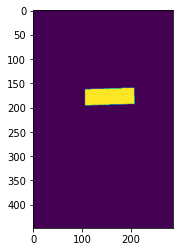

In [5]:
img = read_image(images[1],(288,448),cv2.IMREAD_COLOR)
imgRes = np.expand_dims(img, axis=0)
maskRes = read_image(masks[1],(288,448),cv2.IMREAD_GRAYSCALE)
plt.imshow(maskRes)

In [6]:
predRes = model.predict(imgRes)


2022-04-17 21:15:37.060257: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-17 21:15:37.078536: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2799925000 Hz
2022-04-17 21:15:37.580427: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-04-17 21:15:38.120519: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2022-04-17 21:15:38.854358: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-04-17 21:15:39.393775: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


In [7]:
predRes[predRes < 0.5] = 0
predRes[predRes >= 0.5] = 255
print(type(predRes))
print(np.unique(predRes))

<class 'numpy.ndarray'>
[  0. 255.]


In [8]:
from segment_image import segmented_image,plate_characters

[res, _] = segmented_image(imgRes[0] * 255 ,predRes[0] * 255)
[mask,_] = segmented_image(imgRes[0] * 255 ,maskRes * 255)

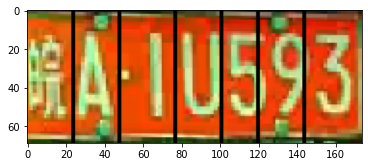

In [9]:
plt.imshow(res)
# plt.imshow(mask)

['A', 'P', '1', '1', '9', 'B']


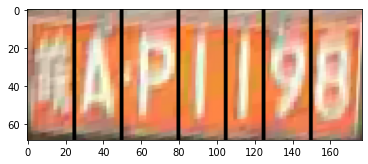

In [10]:
img = read_image(images[2],(288,448),cv2.IMREAD_COLOR)


plt.imshow(img)
[characters,segResult,resultMaps,segImg] = plate_characters(img,model,model_classification)
print(characters)
plt.imshow(segResult)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


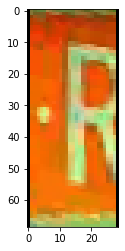

In [11]:
print(resultMaps[1])
plt.imshow(segImg[1])

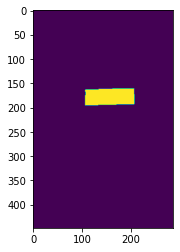

In [12]:
plt.imshow(predRes[0])

def getBoundingBoxFromMask(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

In [13]:
img = cv2.resize(imgRes[0],(720,1160),interpolation = cv2.INTER_NEAREST)
pred = cv2.resize(predRes[0],(720,1160),interpolation = cv2.INTER_NEAREST)

img = img.astype(np.uint8)
pred = pred.astype(np.uint8)

contours,_ = cv2.findContours(pred, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

approx = cv2.approxPolyDP(contours[0], 0.07 * cv2.arcLength(contours[0], True), True)
box = np.squeeze(approx, axis=1)

heigth = 70
width = 180

pt2 = np.float32([[0,0], [width,0], [0,heigth], [width,heigth]])

if box[0][0] < box[2][0]:
    pt12 = np.float32([box[0],box[3],box[1],box[2]])
else:
    pt12 = np.float32([box[1],box[0],box[2],box[3]])
    

f = cv2.getPerspectiveTransform(pt12,pt2)
f2 = cv2.warpPerspective(img,f,(width,heigth))


gray = cv2.cvtColor(f2,cv2.COLOR_BGR2GRAY)
# gray = f2[:,:,2]
# gray = cv2.bilateralFilter(gray,11,17,17)
canny = cv2.Canny(gray,40,200)
# lines = cv2.HoughLinesP(canny,1,np.pi/180,10, maxLineGap=150)

lines = cv2.HoughLinesP(canny,0.001,np.pi/180,3, minLineLength=40, maxLineGap=180)

# if lines is None:
#     break


hough = np.zeros((heigth,width), np.uint8)
hough = canny.copy()

if lines is not None:
    for line in lines:
        x1,y1,x2,y2 = line[0]
        cv2.line(hough,(x1,y1),(x2,y2),(255),1)
            

kernel = np.ones((int(heigth * 0.1)), dtype=np.uint8) * 255

opening = cv2.morphologyEx(hough, cv2.MORPH_OPEN, kernel)

boxop = getBoundingBoxFromMask(opening).astype(int)

result = f2[boxop[0]:boxop[2],boxop[1]:boxop[3]]

if not result.any():
    result = f2.copy()
resultSeg = result.copy()

he, wi,dm = resultSeg.shape
div = int(wi/7)

divs = [i * div + 5 for i in range(1,7)]
divs[0] = divs[0] - 5
divs[1] = divs[1] - 5
divs[-2] = divs[-2] - 5
divs[-1] = divs[-1] - 5


for i in divs:
    resultSeg[:,i-1:i+1] = 0

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

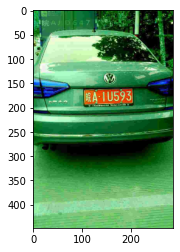

In [14]:
rr = imgRes[0] * 255
rr = rr.astype(np.uint8)
print(np.unique(rr))
plt.imshow(rr)